In [2]:
!pip install tensorflow==2.17.0 keras==3.4.1 tensorflow-decision-forests==1.10.0 tensorflow-text==2.17.0 tf-keras==2.17.0 keras_cv

## 🌐 Connect Colab to Google Drive

In [ ]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 1

## ⚙️ Import Libraries

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras import layers as layers
from tensorflow.keras.callbacks import LambdaCallback
import keras
import keras_cv
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

np.random.seed(42)
tf.random.set_seed(42);

2024-11-23 16:07:21.281969: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-23 16:07:21.302656: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-23 16:07:21.309121: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
PATH_TRAINING_SET = "/kaggle/input/training-set/training_set.npz"
assert PATH_TRAINING_SET != "", "PATH_TRAINING_SET cannot be empty."

## ⏳ Load the Data

In [5]:
data = np.load(PATH_TRAINING_SET)
X = data['images']
y = data['labels']

In [6]:
labels = {
    0: 'Basophil',
    1: 'Eosinophil',
    2: ' Erythroblast',
    3: 'Immature granulocytes',
    4: 'Lymphocyte',
    5: 'Monocyte',
    6: 'Neutrophil',
    7: 'Platelet'
}

unique_labels = list(labels.values())

print('Labels:\n', unique_labels)

Labels:
 ['Basophil', 'Eosinophil', ' Erythroblast', 'Immature granulocytes', 'Lymphocyte', 'Monocyte', 'Neutrophil', 'Platelet']


## Preprocessing

In [7]:
# Define a function to display images
def display_images(
    X=X,
    y=y,
    labels=unique_labels,
    num_images=8
):
    random_indices = random.sample(range(len(X)), num_images)

    fig, axes = plt.subplots(2, num_images // 2, figsize=(20, 9))

    for i, idx in enumerate(random_indices):
        ax = axes[i // 4, i % 4]
        ax.imshow(X[idx])

        class_name = unique_labels[y[idx][0]]
        ax.set_title(class_name, pad=5)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

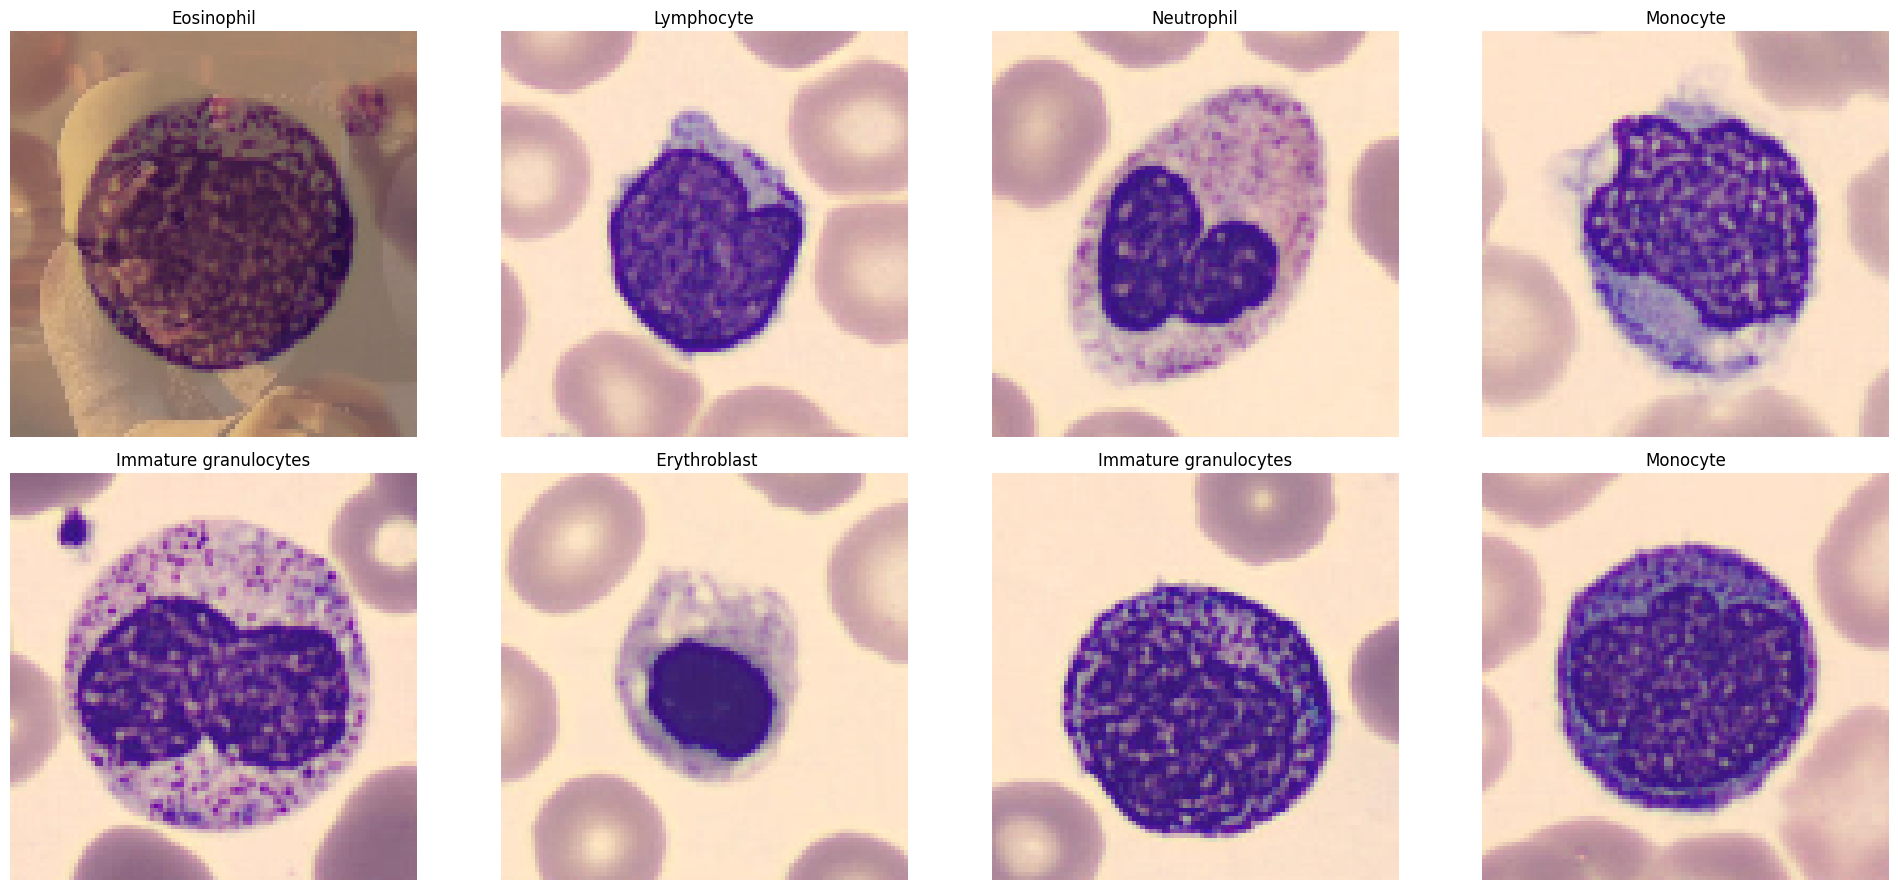

In [8]:
display_images(X, y)

### Removing duplicates (outliers)

In [9]:
# Eliminate duplicates
X_unique, idx, count = np.unique(X, return_index=True, return_counts=True, axis=0)
print(idx.shape)

index = [idx[i] for i in range(idx.shape[0]) if count[i] == 1]

print(f'Dataset (duplicates) Shape: {X.shape}')

X = X[index]
y = y[index]

print(f'Dataset (no duplicates) Shape: {X.shape}')

(11953,)
Dataset (duplicates) Shape: (13759, 96, 96, 3)
Dataset (no duplicates) Shape: (11943, 96, 96, 3)


### Balancing the classes

In [10]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.2),
])

# Extract unique classes and their counts
unique, counts = np.unique(y, return_counts=True)
class_counts = dict(zip(unique, counts))
print("Original distribution:", class_counts)

# Maximum number of samples for a class
max_samples = max(class_counts.values())

# New balanced dataset
X_balanced = []
y_balanced = []

# Oversampling for each class
for cls in class_counts:
    # Filter samples for the current class
    X_class = X[np.where(y == cls)[0]]
    y_class = y[y == cls]
    
    # Calculate the number of samples to add
    samples_to_add = max_samples - len(X_class)
    
    if samples_to_add > 0:
        # Augment the samples to add
        augmented_images = []
        for _ in range(samples_to_add):
            augmented_image = data_augmentation(X_class[np.random.randint(len(X_class))][np.newaxis, ...])
            augmented_images.append(augmented_image.numpy()[0])
        
        # Add the original and augmented samples to the balanced dataset
        X_balanced.append(np.concatenate([X_class, np.array(augmented_images)]))
        y_balanced.append(np.concatenate([y_class, np.full(samples_to_add, cls)]))
    else:
        # Add the original samples to the balanced dataset (if no oversampling is needed)
        X_balanced.append(X_class)
        y_balanced.append(y_class)

# Concatenate the balanced dataset
X = np.concatenate(X_balanced)
y = np.concatenate(y_balanced)

# Check the new distribution
unique_balanced, counts_balanced = np.unique(y_balanced, return_counts=True)
class_counts_balanced = dict(zip(unique_balanced, counts_balanced))
print("Balanced distribution of classes:", class_counts_balanced)


I0000 00:00:1732378067.605231      30 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732378067.605638      30 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732378067.618274      30 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732378067.618603      30 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Original distribution: {0: 848, 1: 2177, 2: 1085, 3: 2020, 4: 849, 5: 991, 6: 2330, 7: 1643}
Balanced distribution of classes: {0: 2330, 1: 2330, 2: 2330, 3: 2330, 4: 2330, 5: 2330, 6: 2330, 7: 2330}


### Converts in one-hot-encoding


In [11]:
y = tf.keras.utils.to_categorical(y, num_classes=8)

## Splitting in training, validation e test set

In [12]:
# split train in training and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.1, 
    random_state=42
)

In [13]:
# split train in training and validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train, 
    y_train, 
    test_size=0.1, 
    random_state=42
)

### Data augmentation

In [14]:
def sample_random_images(dataset, sample_size=5):
    random_samples = dataset.shuffle(buffer_size=1000).take(sample_size)
    images = []
    labels = []
    for image, label in random_samples:
        images.append(image.numpy())
        labels.append(label.numpy())
    return tf.convert_to_tensor(images), tf.convert_to_tensor(labels)

X_train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

In [15]:
def augment(images, labels):
    
    augmenter = keras_cv.layers.Augmenter(
    layers = [
            keras_cv.layers.RandomFlip(
                mode="horizontal_and_vertical"
            ),
            keras_cv.layers.RandomRotation(
                factor=0.2,
                fill_mode='nearest'
            ),
            keras_cv.layers.MixUp(
                alpha=0.5,
            ),
            keras_cv.layers.CutMix(
                alpha=0.5
            ),

            keras_cv.layers.RandomCutout(0.075, 0.075, fill_mode="gaussian_noise"),
            keras_cv.layers.RandomCutout(0.075, 0.075, fill_mode="gaussian_noise"),
            keras_cv.layers.RandomCutout(0.075, 0.075, fill_mode="gaussian_noise"),
            keras_cv.layers.RandomCutout(0.075, 0.075, fill_mode="gaussian_noise"),
            keras_cv.layers.RandomCutout(0.075, 0.075, fill_mode="gaussian_noise"),

        ]
    )
        
    inputs = {"images": images, "labels": labels}
    output = augmenter(inputs)
    return output["images"], output["labels"]

In [16]:
random_X, random_y = sample_random_images(X_train_dataset, 4000)
aug_images, aug_labels = augment(random_X, random_y)

### Plotting some augmented images

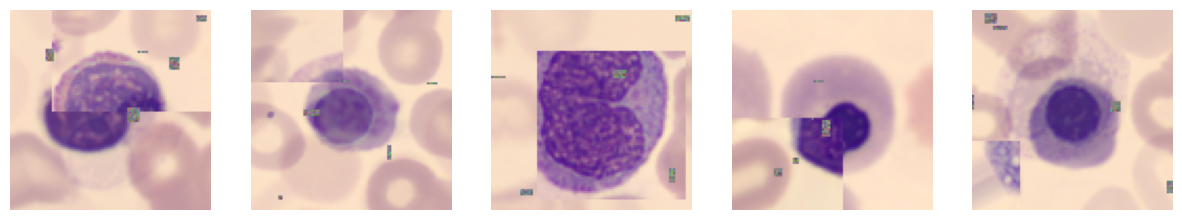

In [17]:
num_images = 5
plt.figure(figsize=(15, 5))  # Adjust the figure size as needed

for i in range(num_images):
    plt.subplot(1, num_images, i + 1)  # Create a 1-row subplot for 10 images
    plt.imshow(aug_images[i] / 255.0)  # Normalize and plot each image
    plt.axis('off')                  # Turn off axis labels for clarity

plt.show()

In [18]:
X_train = tf.concat([X_train, aug_images], axis=0)
y_train = tf.concat([y_train, aug_labels], axis=0)

### Stronger augmentation

In [19]:
randaugmenter = tf.keras.Sequential([
    keras_cv.layers.RandAugment([0, 255], 3, 0.4)
])

augmix = tf.keras.Sequential([
    keras_cv.layers.AugMix([0, 255])
])

def apply_randaugment(image):
    return randaugmenter(image)

def apply_augmix(image):
    return augmix(image)

def apply_augmentation(image, is_randaugment):
    if is_randaugment:
        return apply_randaugment(image)
    else:
        return apply_augmix(image)

batch_size = 256
half_size = len(X_train) // 2

dataset_randaugment = tf.data.Dataset.from_tensor_slices(X_train[:half_size])
dataset_randaugment = dataset_randaugment.map(lambda x: apply_augmentation(x, is_randaugment=True), num_parallel_calls=tf.data.AUTOTUNE)

dataset_augmix = tf.data.Dataset.from_tensor_slices(X_train[half_size:])
dataset_augmix = dataset_augmix.map(lambda x: apply_augmentation(x, is_randaugment=False), num_parallel_calls=tf.data.AUTOTUNE)

dataset = dataset_randaugment.concatenate(dataset_augmix)
dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

X_train = tf.concat([batch for batch in dataset], axis=0)

del X_train_dataset

### Plotting some augmented images

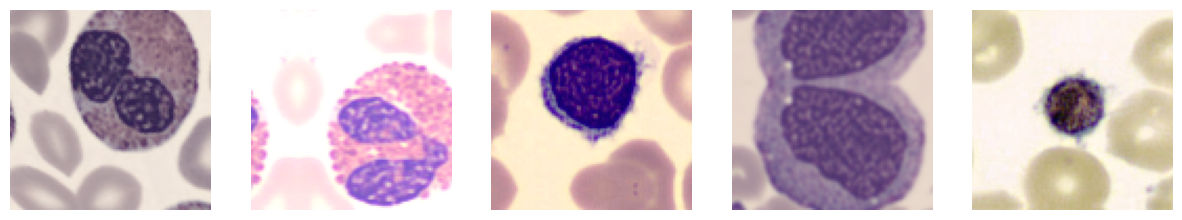

In [20]:
num_images = 5
plt.figure(figsize=(15, 5))  # Adjust the figure size as needed

for i in range(num_images):
    plt.subplot(1, num_images, i + 1)  # Create a 1-row subplot for 10 images
    plt.imshow(X_train[i] / 255.0)    # Normalize and plot each image
    plt.axis('off')                  # Turn off axis labels for clarity

plt.show()

## 🛠️ Train and Save the Model

In [ ]:
class MyModel:
    def __init__(self):
        """
        Initializes the internal state of the pre-trained model.
        """
        self.strategy = tf.distribute.MirroredStrategy()
        self.neural_network = self.create_model()
        
    def get_augmentation_layer(self):
        return tf.keras.Sequential([
            # Random rotation
            keras.layers.RandomRotation(0.5, fill_mode='reflect'),

            # Random zoom in height
            keras.layers.RandomZoom(height_factor=(-0.2, 0.7), fill_mode='nearest'),

            # Other types of augmentations
            keras.layers.RandomZoom(height_factor=(0.0, 0.0), width_factor=(-0.3, 0.3), fill_mode='nearest'),
            keras.layers.RandomFlip(mode="horizontal"),
            keras.layers.RandomFlip(mode="vertical"),
            keras.layers.RandomTranslation(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),
            
            keras.layers.RandomBrightness(0.3),
            #keras_cv.layers.RandomHue(0.3, [0,255]),
            keras_cv.layers.RandomContrast([0, 255], 0.3),
            keras_cv.layers.RandomGaussianBlur(2, 2),
            #keras_cv.layers.RandomCutout(0.3, 0.3,"gaussian_noise"),

            # Adding Gaussian noise
            keras.layers.GaussianNoise(0.07)
        ])

    def create_model(self):
        """
        Creates and returns a model
        """
        # Define data augmentation layers
        data_augmentation = self.get_augmentation_layer()
        
        with self.strategy.scope():

            # Use a pre-trained network
            model_pretrained = tfk.applications.ConvNeXtBase(
                input_shape=(96, 96, 3),
                include_top=False,
                weights='imagenet',
                pooling=None
            )
            self.model_name_pretrained = 'convnext_base'

            print("number of layers:")
            print(len(model_pretrained.layers))

            # Build the model
            inputs = tfk.Input(shape=(96, 96, 3), name='input_layer')    
            x = data_augmentation(inputs)
            x = model_pretrained(x) 
            
            # Batch Normalization after the pre-trained model
            x = tfk.layers.BatchNormalization()(x)

            # Squeeze-and-Excitation (SE Block)
            se = tfk.layers.GlobalAveragePooling2D()(x)  # Reduces to (batch_size, channels)
            se = tfk.layers.Dense(se.shape[-1] // 16, activation='relu')(se)  # Compress
            se = tfk.layers.Dense(se.shape[-1] * 16, activation='sigmoid')(se)  # Expand
            x = tfk.layers.Multiply()([x, tfk.layers.Reshape((1, 1, -1))(se)])  # Scale channels

            # Global Pooling (to reduce dimensionality)
            x = tfk.layers.GlobalAveragePooling2D()(x)

            # Fully Connected layers with Batch Normalization and Leaky ReLU
            x = tfk.layers.Dense(512)(x)
            x = tfk.layers.BatchNormalization()(x)
            x = tfk.layers.LeakyReLU(alpha=0.1)(x)
            x = tfk.layers.Dropout(0.3)(x)

            x = tfk.layers.Dense(256)(x)
            x = tfk.layers.BatchNormalization()(x)
            x = tfk.layers.LeakyReLU(alpha=0.1)(x)
            x = tfk.layers.Dropout(0.3)(x)
            
            outputs = tfk.layers.Dense(8, activation='softmax', name='output_layer')(x)

            model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

            return model

    def train_transfer_learning(self, X_train, y_train, X_test, y_test, epochs=10, batch_size=32):
        """
        Pre-trains the model with frozen layers.
        """

        with self.strategy.scope():  # Ensure training happens inside strategy scope

            self.neural_network.get_layer(self.model_name_pretrained).trainable = False

            # Unlock convolutional layers from the `fine_tune_from` layer onward
            for i, layer in enumerate(self.neural_network.get_layer(self.model_name_pretrained).layers):
                layer.trainable = False

            # Recompile the model (necessary after changing trainable layers)
            self.neural_network.compile(
                loss=tfk.losses.CategoricalCrossentropy(),
                optimizer=tfk.optimizers.Lion(learning_rate=1e-3),
                metrics=['accuracy']
            )

            # Callbacks
            save_every_10 = LambdaCallback(
                on_epoch_end=lambda epoch, logs:
                self.neural_network.save(f'model_epoch_{epoch + 1}.keras') if (epoch + 1) % 10 == 0 else None
            )
            early_stopping = tfk.callbacks.EarlyStopping(
                monitor='val_accuracy',
                mode='max',
                patience=10,
                restore_best_weights=True
            )
        
            # Retrain the model
            history = self.neural_network.fit(
                X_train,
                y_train,
                batch_size=batch_size,
                epochs=epochs,
                shuffle=True,
                validation_data=(X_test, y_test),
                callbacks=[save_every_10, early_stopping]
            )

            return history

    def train_fine_tuning(self, X_train, y_train, X_test, y_test, epochs=10, batch_size=32, fine_tune_from=50):
        """
        Unlocks selected layers and retrains the model.
        """

        with self.strategy.scope():  # Ensure training happens inside strategy scope

            self.neural_network.get_layer(self.model_name_pretrained).trainable = True

            # Unlock convolutional layers from the `fine_tune_from` layer onward
            for i, layer in enumerate(self.neural_network.get_layer(self.model_name_pretrained).layers):
                layer.trainable = False
                if i > fine_tune_from:
                    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.DepthwiseConv2D):
                        print(True)  
                        layer.trainable = True

            # Recompile the model with a lower learning rate
            self.neural_network.compile(
                loss=tfk.losses.CategoricalCrossentropy(),
                optimizer=tfk.optimizers.Lion(learning_rate=1e-4),
                metrics=['accuracy']
            )

            # Callbacks
            save_every_5 = LambdaCallback(
                on_epoch_end=lambda epoch, logs:
                self.neural_network.save(f'model_epoch_{epoch + 1}.keras') if (epoch + 1) % 10 == 0 else None
            )
            early_stopping = tfk.callbacks.EarlyStopping(
                monitor='val_accuracy',
                mode='max',
                patience=5,
                restore_best_weights=True
            )
            
            # Retrain the model
            history = self.neural_network.fit(
                X_train,
                y_train,
                batch_size=batch_size,
                epochs=epochs,
                shuffle=True,
                validation_data=(X_test, y_test),
                callbacks=[save_every_5, early_stopping]
            )
            
            return history

    
    def plot_history(self, history):
        # Extract the history data
        history_data = history.history
    
        # Extract the number of epochs
        epochs = range(1, len(history_data["loss"]) + 1)
    
        # Plot loss and validation loss
        plt.figure(figsize=(14, 5))
    
        # Subplot 1: Loss
        plt.subplot(1, 2, 1)
        plt.plot(epochs, history_data["loss"], label="Training Loss", marker="o")
        plt.plot(epochs, history_data["val_loss"], label="Validation Loss", marker="o")
        plt.title("Training and Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
    
        # Subplot 2: Accuracy
        plt.subplot(1, 2, 2)
        plt.plot(epochs, history_data["accuracy"], label="Training Accuracy", marker="o")
        plt.plot(epochs, history_data["val_accuracy"], label="Validation Accuracy", marker="o")
        plt.title("Training and Validation Accuracy")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()
    
        # Show the plots
        plt.tight_layout()
        plt.show()


    def test(self, X_test, y_test):
        """
        Evaluates the model on test data X_test and labels y_test.
        """
        test_loss, test_acc = self.neural_network.evaluate(X_test, y_test)
        print(f'Test accuracy: {test_acc}')
        
    def load(self, path):
        """
        Loads a model from the specified path.
        """
        with self.strategy.scope():
            self.neural_network = tfk.models.load_model(path) 
            self.neural_network.compile(
                loss=tfk.losses.CategoricalCrossentropy(),
                optimizer=tfk.optimizers.Lion(),
                metrics=['accuracy']
            )
    
    def save(self):
        """
        Saves the model.
        """
        self.neural_network.save('/gdrive/MyDrive/[2024-2025] AN2DL/Homework 1/weights.keras')

    def predict(self, X):
        """
        Predicts labels for the input X.
        """
        preds = self.neural_network.predict(X)
        return preds


In [22]:
model = MyModel()

350926856/350926856 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
number of layers:
259


Epoch 1/50


W0000 00:00:1732378448.105462     121 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732378448.175491     121 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732378448.177868     121 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732378448.180146     121 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732378448.182303     121 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732378448.184361     121 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732378448.186838     121 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732378448.189275     121 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732378448.191944     121 gp

37/38 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.3405 - loss: 1.8926

W0000 00:00:1732378545.023075     119 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732378545.024030     119 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732378545.024969     119 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732378545.025897     119 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732378545.026721     122 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732378545.026771     119 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732378545.027879     119 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732378545.028430     122 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732378545.028990     119 gp

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3430 - loss: 1.8852

W0000 00:00:1732378561.324920     119 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732378561.325893     119 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732378561.326820     119 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732378561.327720     121 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732378561.327732     119 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732378561.329272     119 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732378561.329907     121 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732378561.330409     119 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732378561.332014     121 gp

38/38 ━━━━━━━━━━━━━━━━━━━━ 158s 3s/step - accuracy: 0.3454 - loss: 1.8786 - val_accuracy: 0.6484 - val_loss: 0.9195
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 117s 3s/step - accuracy: 0.5475 - loss: 1.3039 - val_accuracy: 0.8164 - val_loss: 0.5719
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 117s 3s/step - accuracy: 0.5962 - loss: 1.1764 - val_accuracy: 0.8594 - val_loss: 0.4264
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 118s 3s/step - accuracy: 0.6266 - loss: 1.1065 - val_accuracy: 0.8713 - val_loss: 0.4513
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 117s 3s/step - accuracy: 0.6379 - loss: 1.0788 - val_accuracy: 0.8582 - val_loss: 0.4602
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 124s 3s/step - accuracy: 0.6446 - loss: 1.0587 - val_accuracy: 0.8903 - val_loss: 0.3650
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 117s 3s/step - accuracy: 0.6442 - loss: 1.0412 - val_accuracy: 0.8892 - val_loss: 0.3637
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 118s 3s/step - accuracy: 0.6624 - loss: 1.0189 - val_accuracy: 0.8808 - val_loss: 0.

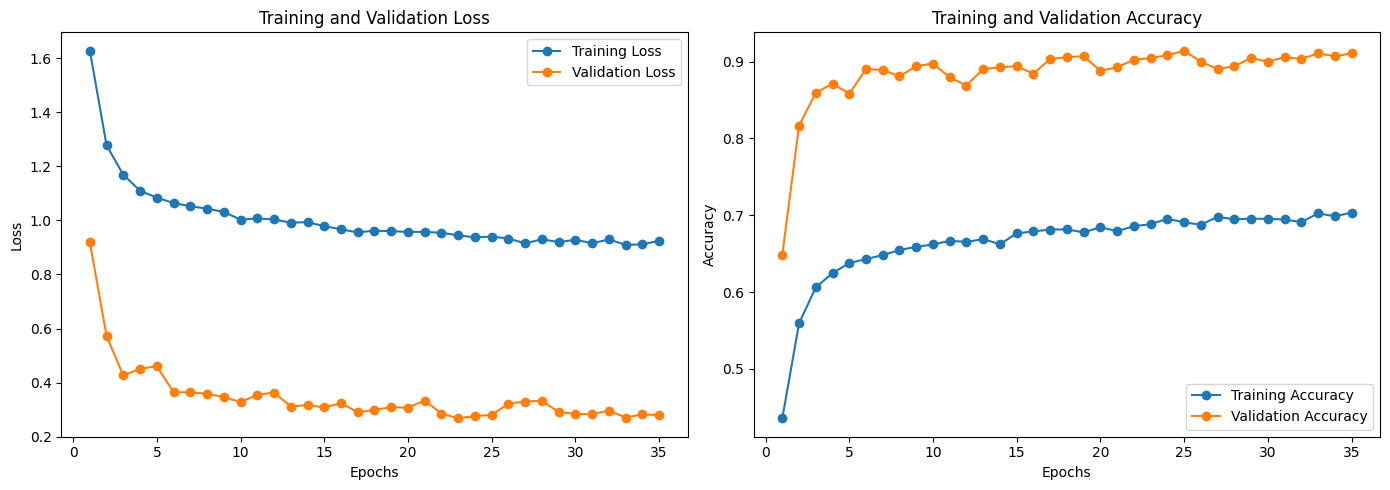

In [23]:
history = model.train_transfer_learning(X_train, y_train, X_val, y_val, 50, 512)
model.plot_history(history)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
Epoch 1/50


W0000 00:00:1732384387.166804     119 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732384387.269600     119 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732384387.270874     120 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732384387.291186     120 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732384387.293255     119 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732384387.323599     120 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732384387.323967     119 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732384387.367393     120 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732384387.386914     119 gp

37/38 ━━━━━━━━━━━━━━━━━━━━ 4s 5s/step - accuracy: 0.6805 - loss: 0.9519

W0000 00:00:1732384570.774536     119 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732384570.777829     119 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732384570.783811     119 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732384570.793248     119 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732384570.857770     121 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732384570.861889     121 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732384570.869550     121 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732384570.881633     121 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732384570.900093     121 gp

38/38 ━━━━━━━━━━━━━━━━━━━━ 255s 5s/step - accuracy: 0.6813 - loss: 0.9499 - val_accuracy: 0.9070 - val_loss: 0.2719
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 206s 5s/step - accuracy: 0.7049 - loss: 0.9005 - val_accuracy: 0.9130 - val_loss: 0.2640
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 209s 5s/step - accuracy: 0.7235 - loss: 0.8604 - val_accuracy: 0.9142 - val_loss: 0.2470
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 208s 5s/step - accuracy: 0.7209 - loss: 0.8487 - val_accuracy: 0.9237 - val_loss: 0.2281
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 207s 5s/step - accuracy: 0.7386 - loss: 0.8098 - val_accuracy: 0.9273 - val_loss: 0.2107
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 207s 5s/step - accuracy: 0.7459 - loss: 0.7992 - val_accuracy: 0.9380 - val_loss: 0.1906
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 209s 5s/step - accuracy: 0.7582 - loss: 0.7696 - val_accuracy: 0.9356 - val_loss: 0.1876
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 205s 5s/step - accuracy: 0.7527 - loss: 0.7732 - val_accuracy: 0.9261 - val_loss: 0.

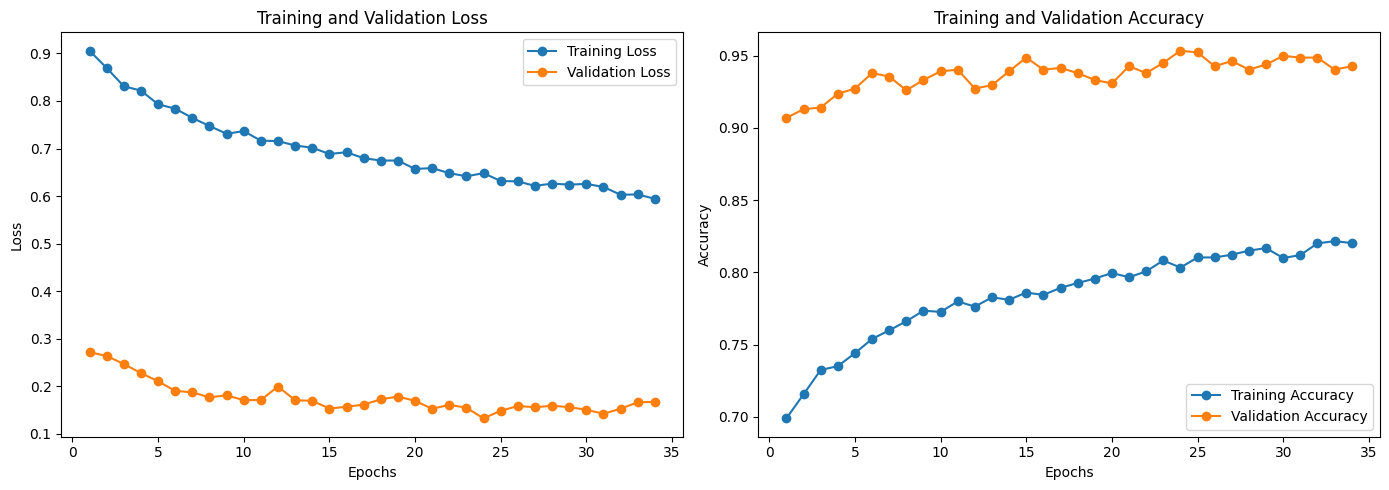

In [26]:
history = model.train_fine_tuning(X_train, y_train, X_val, y_val, 50, 512, 150)
model.plot_history(history)

## Evaluation

In [27]:
model.test(X_test, y_test)

W0000 00:00:1732391423.462385     120 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732391423.463837     120 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732391423.464817     121 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732391423.465159     120 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732391423.466207     121 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732391423.466788     120 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732391423.468389     120 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732391423.468542     121 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732391423.470245     120 gp

58/59 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9550 - loss: 0.1422

W0000 00:00:1732391434.476692     122 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732391434.476692     120 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732391434.478100     120 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732391434.478100     122 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732391434.479437     120 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732391434.479437     122 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732391434.480770     120 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732391434.480770     122 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1732391434.482085     122 gp

59/59 ━━━━━━━━━━━━━━━━━━━━ 18s 188ms/step - accuracy: 0.9552 - loss: 0.1415
Test accuracy: 0.9688841104507446


#### Evaluating with augmented test set

In [28]:
randaugmenter = tf.keras.Sequential([
    keras_cv.layers.RandAugment([0, 255], 3, 0.4)
])

augmented_test = randaugmenter(X_test)
augmented_test = model.get_augmentation_layer()(augmented_test)

In [29]:
model.test(augmented_test, y_test)

59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 0.8064 - loss: 0.5709
Test accuracy: 0.8154506683349609


### Plotting confusion matrix

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, f1_score

def plot_confusion_matrix(y_true, y_pred):
    
    cm = confusion_matrix(y_true, y_pred)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)  
    plt.title("Confusion Matrix")
    plt.show()


def evaluate_model(y_true, y_pred):
    # Convert one-hot encoding to class labels for precision, recall, and accuracy
    if len(y_true.shape) > 1 and y_true.shape[1] > 1:
        y_true_labels = np.argmax(y_true, axis=1)
        y_pred_labels = np.argmax(y_pred, axis=1)
    else:
        y_true_labels = y_true
        y_pred_labels = y_pred

    # Compute metrics
    precision = precision_score(y_true_labels, y_pred_labels, average="weighted")
    recall = recall_score(y_true_labels, y_pred_labels, average="weighted")
    accuracy = accuracy_score(y_true_labels, y_pred_labels)
    roc_auc = roc_auc_score(y_true, y_pred, multi_class="ovr")
    f1 = f1_score(y_true_labels, y_pred_labels,average='weighted')


    # Print metrics
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Plot confusion matrix
    cm = confusion_matrix(y_true_labels, y_pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step
Precision: 0.9543
Recall: 0.9523
Accuracy: 0.9523
ROC AUC: 0.9982
F1 Score: 0.9525


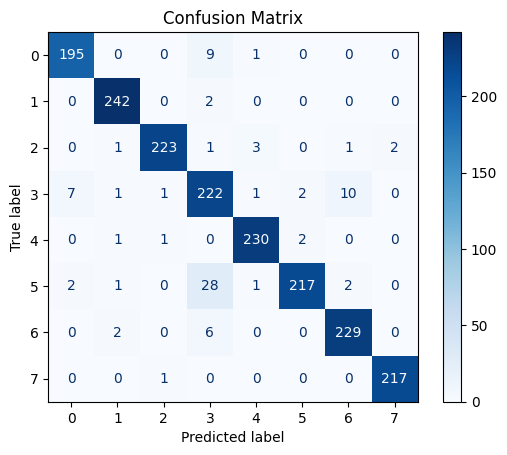

In [33]:
preds = model.predict(X_test)
evaluate_model(y_test, preds)

Evaluating with augmented test set

59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 163ms/step
Precision: 0.8069
Recall: 0.8074
Accuracy: 0.8074
ROC AUC: 0.9761
F1 Score: 0.8059


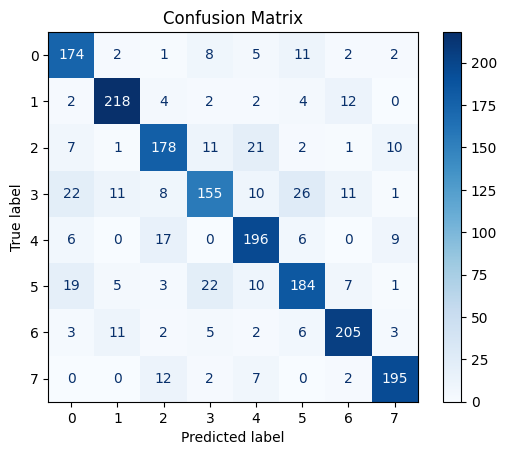

In [34]:
preds_augmented = model.predict(augmented_test)
evaluate_model(y_test, preds_augmented)

## 📊 Saving

In [ ]:
model.neural_network.save('weights.keras')

In [ ]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


class Model:
    def __init__(self):
        self.neural_network = tfk.models.load_model('weights.keras')

    def predict(self, X):
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

In [ ]:
from datetime import datetime
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Add files to the zip command if needed
!zip {filename} model.py weights.keras

from google.colab import files
files.download(filename)